In [1]:
import pdb
import numpy as np
import os
from VieroLibrary import readcol
from lmfit import Parameters, minimize, fit_report
import math
import cPickle as pickle
import pylab
import pylab as plt

%matplotlib inline  

In [2]:
class Catalog:
    '''To collect all the SEDs'''
    def __init__(self):
        seds = np.array([])
    def add_sed(sed):
        seds.append(sed)
    
class SED:
    def __init__(self,idx,rfwavelength,flux):
        self.analogs = []
        self.atot = np.sum(self.analogs)
    def add_analog(ida):
        self.analogs = np.append(self.analogs, ida)

In [3]:
UVISTA = Catalog()

In [4]:
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]
def find_nearest_index(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

In [19]:
def compare_seds(seda,sedsb,u=0.05):
    a12 = (np.sum(seda * sedsb,axis=0) / np.sum(sedsb**2,axis=0) )
    #b12 = np.sqrt(np.sum(seda - np.multiply(a12,sedsb.T).T,axis=1)**2 / np.sum(seda)**2 ) 
    b12 = np.sqrt(np.sum(10**(np.log10(seda) - np.log10(np.multiply(a12,sedsb.T).T))**2,axis=1)/np.sum(seda)**2)
    #pdb.set_trace()
    idx = np.where((b12 > 0) & (b12 < u) )
    return [idx[0],a12[idx]]

In [6]:
def compare_all_seds(seds,u=0.05):
    ng = np.shape(seds)[0]
    nlam = np.shape(seds)[1]
    #pdb.set_trace()
    sedtile = np.tile(seds,(ng)).reshape(ng,ng,nlam)
    #sedtile = np.tile(np.reshape(seds,(1,ng,nlam)),(ng,1,1))
    
    a12_num = np.sum(np.multiply(sedtile,seds),axis=2) 
    a12_denom = np.sum(seds**2,axis=1) 
    a12 = (a12_num / a12_denom) 
    a12_tile = np.tile(np.reshape(a12,(ng,ng,1)),(1,1,nlam))

    #b12 = np.sqrt(np.sum(10**(np.log10(sedtile) - np.log10(np.multiply(a12,sedtile.T).T))**2,axis=2) / np.sum(seds,axis=1)**2)
    #b12 = np.sqrt(np.sum(10**(np.log10(sedtile) - np.log10(np.multiply(a12_tile,sedtile)))**2,axis=2) / np.sum(seds,axis=1)**2)
    
    b12 = np.zeros([ng,ng])
    for j in range(ng):
        seda = seds[j,:]
        tmp = np.sqrt(np.sum(10**(np.log10(seda) - np.log10(np.multiply(a12[j,:],seds.T).T))**2,axis=1)/np.sum(seda)**2)
        b12[j,:] = tmp
    #pdb.set_trace()
    #idx = np.where((b12 > 0) & (b12 < u) )
    idx = (b12 > 0) & (b12 < u)
    return idx

In [7]:
def extract_parent_and_analog_seds(idx):
    ind_max = np.argmax(np.sum(idx,axis=1))
    ind_analogs = np.where(idx[ind_max] == True)[0]
    ind_else    = np.where(idx[ind_max] == False)[0]
    #pdb.set_trace()
    return [ind_max, ind_analogs, ind_else]

In [8]:
path_catalog = '/data/maps_cats_models/catalogs/UVISTA/'
file_catalog = 'UVISTA_final_v4.1_zCOSMOS_zEAZY_RFcolors_IDs_mass_AGN_SFRs.csv'

In [9]:
id0,ra0,dec0,mips24_0,z_peak0,u_v0,v_j0,reddening_AGN0,a_hat_AGN0,F_ratio0,l_uv0,l_ir0,sfr_uv,lmass0 = readcol.readcol(path_catalog+file_catalog,fsep=',',twod=False, skipline=1)

In [10]:
lamlo = 1200
lamhi = 50000
nlam = 22
rflam = 10**np.linspace(np.log10(lamlo), np.log10(lamhi),nlam)
path_compressed_seds = '/data/SEDs/UVISTA/Muzzin13/K-Selected/'
file_compressed_seds = 'test_1000_UVISTA_final_v4.1_zCOSMOS_zEAZY_RFcolors_Downsampled_'+str(int(lamlo))+'-'+str(int(lamhi))+'A_'+str(int(nlam))+'bins2.p'
all_downsampled_spectra = pickle.load( open( path_compressed_seds+file_compressed_seds, "rb" ) )

In [18]:
ng=500#3000
uin=0.050
seda = all_downsampled_spectra[:,2]
sedsb = all_downsampled_spectra[:,:ng]
print np.shape(seda)
print np.shape(sedsb)
tst = compare_seds(seda,sedsb,u=uin)#0.005)
print len(tst[1])

(22,)
(22, 500)


ValueError: operands could not be broadcast together with shapes (22,) (500,) 

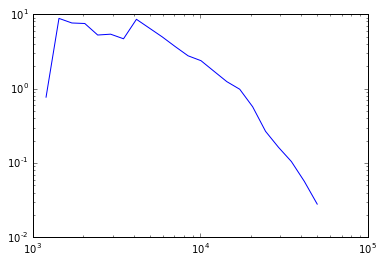

In [204]:
parent_sed = seda
analog_seds= sedsb[tst[0]]
a12_analogs= tst[1]
n_parents = len(tst[1]) # 30
pylab.figure()
plt.loglog(rflam,parent_sed)
    
for i in range(n_parents):
    #plt.loglog(rflam,a12_analogs[i]*analog_seds[i],'+')
    plt.loglog(rflam,analog_seds[i],'+')
        
plt.show()

In [205]:
#idin = np.random.choice(range(len(id0)),ng,replace=False)
#seds2 = all_downsampled_spectra[indin]

In [206]:
seds2 = sedsb

In [207]:
tst2 = compare_all_seds(seds2,u=uin)
tst2

array([[ True, False,  True, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [ True,  True,  True, ..., False,  True, False],
       ..., 
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ...,  True,  True,  True]], dtype=bool)

In [208]:
print np.sum(tst2,axis=0).max()
print np.sum(tst2,axis=0).argmax()
#np.sum(tst2,axis=0)

273
168


In [209]:
tout = extract_parent_and_analog_seds(tst2)
print tout[0]
print len(tout[1])

210
496


IndexError: index 49 is out of bounds for axis 0 with size 49

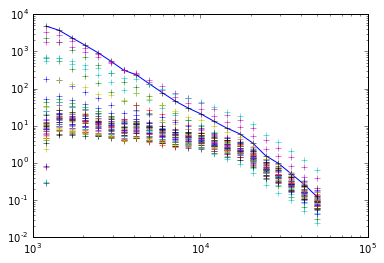

In [160]:
tout = extract_parent_and_analog_seds(tst2)
#[ind_max, ind_analogs, ind_else]
parent_sed = seds2[tout[0]]
analog_seds= seds2[tout[1]]
remaining_seds=seds2[tout[2]]
n_parents = 30
for j in range(n_parents):
    pylab.figure()
    plt.loglog(rflam,parent_sed)
    
    for i in range(50):
        #plt.loglog(rflam,seds[ind_analogs[0][i]],'+')
        plt.loglog(rflam,analog_seds[i],'+')
    
    tst2 = compare_all_seds(remaining_seds,u=uin)
    tout2 = extract_parent_and_analog_seds(tst2)
    parent_sed = remaining_seds[tout2[0]]
    analog_seds= remaining_seds[tout2[1]]
    remaining_seds=remaining_seds[tout2[2]]
    
    plt.show()

# CUT BELOW EVENTUALLY